In [65]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
protomf_path = Path("./ProtoMF/")
sys.path.append(protomf_path.__str__())

import argparse
import os
from confs.hyper_params import mf_hyper_params, anchor_hyper_params, user_proto_chose_original_hyper_params, \
    item_proto_chose_original_hyper_params, proto_double_tie_chose_original_hyper_params
from experiment_helper import start_hyper, start_multiple_hyper
from utilities.consts import SINGLE_SEED


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import os
import torch
from ray import tune
from torch import nn
from torch.utils import data
from feature_extraction.feature_extractor_factories import FeatureExtractorFactory
from rec_sys_folder.rec_sys import RecSys
from utilities.consts import OPTIMIZING_METRIC, MAX_PATIENCE
from utilities.eval import Evaluator
import numpy as np
import pandas as pd
from scipy import sparse as sp
from torch.utils import data
from torch.utils.data.dataset import T_co
from functools import partial
import torch
from torch import nn
from feature_extraction.feature_extractors import FeatureExtractor
import argparse
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from rec_sys_folder.protomf_dataset import get_protorecdataset_dataloader
from rec_sys_folder.tester import Tester
from rec_sys_folder.trainer import Trainer
from utilities.consts import NEG_VAL, OPTIMIZING_METRIC, SEED_LIST, SINGLE_SEED, NUM_SAMPLES, \
    PROJECT_NAME, DATA_PATH, NUM_WORKERS, CPU_PER_TRIAL, GPU_PER_TRIAL, WANDB_API_KEY
from ray.air.integrations.wandb import WandbLoggerCallback
from utilities.utils import reproducible, generate_id
import platform

In [67]:
torch.cuda.is_available()

True

In [68]:
import wandb

In [69]:
def load_data(conf: argparse.Namespace, is_train: bool = True):
    if is_train:
        train_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='train',
            n_neg=conf.neg_train,
            neg_strategy=conf.train_neg_strategy,
            batch_size=conf.batch_size,
            shuffle=True,
            num_workers=NUM_WORKERS,
            prefetch_factor=5
        )

        val_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='val',
            n_neg=NEG_VAL,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=NUM_WORKERS
        )
        
        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=NEG_VAL,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=NUM_WORKERS
        )

        return {'train_loader': train_loader, 'val_loader': val_loader, 'test_loader': test_loader}
    else:

        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=NEG_VAL,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=NUM_WORKERS
        )

        return {'test_loader': test_loader}


def start_training(config):
    config = argparse.Namespace(**config)
    print(config)

    data_loaders_dict = load_data(config)

    reproducible(config.seed)

    # trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'], data_loaders_dict['test_loader'], config)
    trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'],  config)


    trainer.run()

    wandb.finish()


def start_testing(config, model_load_path: str):
    config = argparse.Namespace(**config)
    print(config)

    data_loaders_dict = load_data(config, is_train=False)

    reproducible(config.seed)

    tester = Tester(data_loaders_dict['test_loader'], config, model_load_path)

    metric_values = tester.test()
    return metric_values


def start_hyper(conf: dict, model: str, dataset: str, seed: int = SINGLE_SEED):
    print('Starting Hyperparameter Optimization')
    print(f'Seed is {seed}')

    # Search Algorithm
    search_alg = HyperOptSearch(random_state_seed=seed)

    if dataset == 'lfm2b-1mon':
        scheduler = ASHAScheduler(grace_period=4)
    else:
        scheduler = None

    # Logger
    callback = WandbLoggerCallback(project=PROJECT_NAME, log_config=True, api_key=WANDB_API_KEY,
                                   reinit=True, force=True, job_type='train/val', tags=[model, str(seed), dataset])

    # Hostname
    host_name = platform.uname()

    # Dataset
    data_path = DATA_PATH
    conf['data_path'] = os.path.join(data_path, dataset)

    # Seed
    conf['seed'] = seed

    group_name = f'{model}_{dataset}_{seed}'
    tune.register_trainable(group_name, start_training)
    analysis = tune.run(
        group_name,
        config=conf,
        name=generate_id(prefix=group_name),
        resources_per_trial={'gpu': GPU_PER_TRIAL, 'cpu': CPU_PER_TRIAL},
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=NUM_SAMPLES,
        callbacks=[callback],
        metric='_metric/' + OPTIMIZING_METRIC,
        mode='max'
    )
    metric_name = '_metric/' + OPTIMIZING_METRIC
    best_trial = analysis.get_best_trial(metric_name, 'max', scope='all')
    best_trial_config = best_trial.config
    best_trial_checkpoint = os.path.join(analysis.get_best_checkpoint(best_trial, metric_name, 'max'), 'best_model.pth')

    wandb.login(key=WANDB_API_KEY)
    wandb.init(project=PROJECT_NAME, group='test_results', config=best_trial_config, name=group_name, force=True,
               job_type='test', tags=[model, str(seed), dataset])
    metric_values = start_testing(best_trial_config, best_trial_checkpoint)
    wandb.finish()
    return metric_values


def start_multiple_hyper(conf: dict, model: str, dataset: str, seed_list: list = SEED_LIST):
    print('Starting Multi-Hyperparameter Optimization')
    print('seed_list is ', seed_list)
    metric_values_list = []
    mean_values = dict()

    for seed in seed_list:
        metric_values_list.append(start_hyper(conf, model, dataset, seed))

    for key in metric_values_list[0].keys():
        _sum = 0
        for metric_values in metric_values_list:
            _sum += metric_values[key]
        _mean = _sum / len(metric_values_list)

        mean_values[key] = _mean

    group_name = f'{model}_{dataset}'

In [81]:
base_param = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 10,
    'eval_neg_strategy': 'uniform',
    'val_batch_size': 256,
    'train_batch_size': 256,
    'data_path': protomf_path / "data/ml",
    'NUM_WORKERS': 1,
    'rec_sys_param': {'use_bias': 0},
}

base_hyper_params = {
    **base_param,
    'neg_train': 99,
    'neg_val': 99,
    'train_neg_strategy': 'uniform',#tune.choice(['popular', 'uniform']),
    'loss_func_name': 'sampled_softmax', # tune.choice(['bce', 'bpr', 'sampled_softmax']),
    'batch_size': np.random.randint(64, 512),
    'optim_param': {
        'optim': 'adagrad',
        'wd': np.random.uniform(low=1e-4, high=1e-2),
        'lr': np.random.uniform(low=1e-4, high=1e-1)
    },
}
user_proto_chose_original_hyper_params = {
    **base_hyper_params,
    'loss_func_aggr': 'mean',
    'ft_ext_param': {
        "ft_type": "prototypes",
        'embedding_dim': np.random.randint(10, 100), #tune.randint(10, 100),
        'user_ft_ext_param': {
            "ft_type": "prototypes",
            'sim_proto_weight': np.random.uniform(low=1e-3, high=10), # tune.loguniform(1e-3, 10),
            'sim_batch_weight': np.random.uniform(low=1e-3, high=10),
            'use_weight_matrix': False,
            'n_prototypes': np.random.randint(10, 100), #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max',
        },
        'item_ft_ext_param': {
            "ft_type": "embedding",
        }
    },
}
user_proto_chose_original_hyper_params = argparse.Namespace(**user_proto_chose_original_hyper_params)

proto_double_tie_chose_original_hyper_params = {
    'loss_func_aggr': 'mean',
    'ft_ext_param': {
        "ft_type": "prototypes_double_tie",
        'embedding_dim': 100, #tune.randint(10, 100),
        'item_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 5, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
        'user_ft_ext_param': {
            "ft_type": "prototypes_double_tie",
            'sim_proto_weight': 1e-3,#tune.loguniform(1e-3, 10),
            'sim_batch_weight': 1e-3, #tune.loguniform(1e-3, 10),
            'use_weight_matrix': False,
            'n_prototypes': 100, #tune.randint(10, 100),
            'cosine_type': 'shifted',
            'reg_proto_type': 'max',
            'reg_batch_type': 'max'
        },
    },
    "checkpoint_dir": 'experiments/full_train_final_experiments_initiailization',
    "user_alpha": 2.5,
    "item_alpha": 5,
    **base_hyper_params,
}

from omegaconf import OmegaConf
# proto_double_tie_chose_original_hyper_params = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)
# proto_double_tie_chose_original_hyper_params = OmegaConf.create(proto_double_tie_chose_original_hyper_params)

In [7]:
# data_loaders_dict = load_data(proto_double_tie_chose_original_hyper_params)
# config = proto_double_tie_chose_original_hyper_params
# trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'],  config)

In [73]:
checkpoint_dir = Path("./ProtoMF/best_models")

In [74]:
class ProtoRecDataset(data.Dataset):
    """
    Dataset class to be used in ProtoRec. To use this class for any dataset, please refer to the splitter functions
    (e.g. movielens_splitter.py)

    This class implements some basic functionalities about negative sampling. The negative sampling for a specific user
    is influenced by the split_set:
        - split_set = train: The other training items are excluded from the sampling.
        - split_set = val: The other validation items and training items are excluded from the sampling.
        - split_set = test: The other test items and training items are excluded from the sampling.

    About the data management and access:
    To perform a fast iteration and sampling over the dataset, we use two sparse matrices (COO and CSR). The COO
    is used for iteration over the training data while the CSR for fast negative sampling. We always load the train
    CSR since it is used to exclude the training data from the negative sampling also for Validation and Testing.
    NB. Depending on the split_set, the matrices may have different data. Train COO and Train CSR have always the
    same data. However, Val CSR has Val + Train data (same applies for test). This is due to the negative sampling
    in the csr matrix, for which we also exclude items from training (see below).
    """

    def __init__(self, data_path: str, split_set: str, n_neg: int, neg_strategy: str = 'uniform'):
        """
        :param data_path: path to the directory with the listening_history_*, item_ids, and user_ids files.
        :param split_set: Value in [train, val, test].
        :param n_neg: Number of negative samples.
        :param neg_strategy: Strategy to select the negative samples.
        """
        assert split_set in ['train', 'val', 'test'], f'<{split_set}> is not a valid value for split set!'

        self.data_path = data_path
        self.split_set = split_set
        self.n_neg = n_neg
        self.neg_strategy = neg_strategy

        self.n_users = None
        self.n_items = None

        self.item_ids = None

        self.coo_matrix = None
        self.csr_matrix = None

        self.pop_distribution = None

        self.load_data()

        print(f'Built ProtoRecDataset module \n'
              f'- data_path: {self.data_path} \n'
              f'- n_users: {self.n_users} \n'
              f'- n_items: {self.n_items} \n'
              f'- n_interactions: {self.coo_matrix.nnz} \n'
              f'- split_set: {self.split_set} \n'
              f'- n_neg: {self.n_neg} \n'
              f'- neg_strategy: {self.neg_strategy} \n')

    def load_data(self):
        print('Loading data')

        user_ids = pd.read_csv(os.path.join(self.data_path, 'user_ids.csv'))
        item_ids = pd.read_csv(os.path.join(self.data_path, 'item_ids.csv'))

        self.n_users = len(user_ids)
        self.n_items = len(item_ids)

        train_lhs = pd.read_csv(os.path.join(self.data_path, 'listening_history_train.csv'))

        train_csr = sp.csr_matrix(
            (np.ones(len(train_lhs), dtype=np.int16), (train_lhs.user_id, train_lhs.item_id)),
            shape=(self.n_users, self.n_items))

        # Computing the popularity distribution (see _neg_sample_popular)
        item_popularity = np.array(train_csr.sum(axis=0)).flatten()
        self.pop_distribution = item_popularity / item_popularity.sum()

        if self.split_set == 'val':
            val_lhs = pd.read_csv(os.path.join(self.data_path, 'listening_history_val.csv'))

            val_csr = sp.csr_matrix(
                (np.ones(len(val_lhs), dtype=np.int16), (val_lhs.user_id, val_lhs.item_id)),
                shape=(self.n_users, self.n_items))

            val_coo = sp.coo_matrix(val_csr)

            self.coo_matrix = val_coo
            self.csr_matrix = val_csr + train_csr

        elif self.split_set == 'test':
            test_lhs = pd.read_csv(os.path.join(self.data_path, 'listening_history_test.csv'))

            test_csr = sp.csr_matrix(
                (np.ones(len(test_lhs), dtype=np.int16), (test_lhs.user_id, test_lhs.item_id)),
                shape=(self.n_users, self.n_items))

            test_coo = sp.coo_matrix(test_csr)

            self.coo_matrix = test_coo
            self.csr_matrix = test_csr + train_csr

        elif self.split_set == 'train':
            train_coo = sp.coo_matrix(train_csr)

            self.coo_matrix = train_coo
            self.csr_matrix = train_csr

    def _neg_sample_uniform(self, row_idx: int) -> np.array:
        """
        For a specific user, it samples n_neg items u.a.r.
        :param row_idx: user id (or row in the matrix)
        :return: npy array containing the negatively sampled items.
        """

        consumed_items = self.csr_matrix.indices[self.csr_matrix.indptr[row_idx]:self.csr_matrix.indptr[row_idx + 1]]

        # Uniform distribution without items consumed by the user
        p = np.ones(self.n_items)
        p[consumed_items] = 0.  # Excluding consumed items
        p = p / p.sum()

        sampled = np.random.choice(np.arange(self.n_items), self.n_neg, replace=False, p=p)

        return sampled

    def _neg_sample_popular(self, row_idx: int) -> np.array:
        """
        For a specific user, it samples n_neg items considering the frequency of appearance of items in the dataset, i.e.
        p(i being neg) ∝ (pop_i)^0.75.
        :param row_idx: user id (or row in the matrix)
        :return: npy array containing the negatively sampled items.
        """
        consumed_items = self.csr_matrix.indices[self.csr_matrix.indptr[row_idx]:self.csr_matrix.indptr[row_idx + 1]]

        p = self.pop_distribution.copy()
        p[consumed_items] = 0.  # Excluding consumed items
        p = np.power(p, .75)  # Squashing factor alpha = .75
        p = p / p.sum()

        sampled = np.random.choice(np.arange(self.n_items), self.n_neg, replace=False, p=p)
        return sampled

    def __len__(self) -> int:
        return self.coo_matrix.nnz

    def __getitem__(self, index) -> T_co:
        """
        Loads the (user,item) pair associated to the index and performs the negative sampling.
        :param index: (user,item) index pair (as defined by the COO.data vector)
        :return: (user_idx,item_idxs,labels) where
            user_idx: is the index of the user
            item_idxs: is a npy array containing the items indexes. The positive item is in the 1st position followed
                        by the negative items indexes. Shape is (1 + n_neg,)
            labels: npy array containing the labels. First position is 1, the others are 0. Shape is (1 + n_neg,).

        """

        user_idx = self.coo_matrix.row[index].astype('int64')
        item_idx_pos = self.coo_matrix.col[index]

        # Select the correct negative sampling strategy
        if self.neg_strategy == 'uniform':
            neg_samples = self._neg_sample_uniform(user_idx)
        elif self.neg_strategy == 'popular':
            neg_samples = self._neg_sample_popular(user_idx)
        else:
            raise ValueError(f'Negative Sampling Strategy <{self.neg_strategy}> not implemented ... Yet')

        item_idxs = np.concatenate(([item_idx_pos], neg_samples)).astype('int64')

        labels = np.zeros(1 + self.n_neg, dtype='float32')
        labels[0] = 1.

        return user_idx, item_idxs, labels

In [75]:
data_path = Path(r".\ProtoMF\data\full_train")
dataset = 'ml'
tst= ProtoRecDataset(data_path, 'train', 10, 'uniform')
tst.__getitem__(0)
tst2 = data.DataLoader(tst)
tst2

tst.__getitem__(3)

Loading data
Built ProtoRecDataset module 
- data_path: ProtoMF\data\full_train 
- n_users: 6028 
- n_items: 3123 
- n_interactions: 559852 
- split_set: train 
- n_neg: 10 
- neg_strategy: uniform 



(0,
 array([ 222, 2349, 1917, 1424,  419, 3029, 1117, 1849, 1373,  382, 2588],
       dtype=int64),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [76]:
def get_protorecdataset_dataloader(data_path: str, split_set: str, n_neg: int, neg_strategy='uniform',
                                   **loader_params) -> data.DataLoader:
    """
    Returns the dataloader for a ProtoRecDataset
    :param data_path, ... ,neg_strategy: check ProtoRecDataset class for info about these parameters
    :param loader_params: parameters for the Dataloader
    :return:
    """
    protorec_dataset = ProtoRecDataset(data_path, split_set, n_neg, neg_strategy)
    return data.DataLoader(protorec_dataset, **loader_params)

In [77]:
def load_data(conf, is_train: bool = True):
    if is_train:
        train_loader = get_protorecdataset_dataloader(
        data_path= conf.data_path,
        split_set='train',
        n_neg=conf.neg_train,
        neg_strategy=conf.train_neg_strategy,
        batch_size=conf.train_batch_size,
        shuffle=True,
        num_workers=conf.NUM_WORKERS,
        prefetch_factor=5
    )

        val_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='val',
            n_neg=conf.neg_val,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=conf.NUM_WORKERS
        )
        
        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=conf.neg_val,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=conf.NUM_WORKERS
        )

        return {'train_loader': train_loader, 'val_loader': val_loader, 'test_loader': test_loader}
    else:

        test_loader = get_protorecdataset_dataloader(
            data_path=conf.data_path,
            split_set='test',
            n_neg=conf.neg_val,
            neg_strategy=conf.eval_neg_strategy,
            batch_size=conf.val_batch_size,
            num_workers=conf.NUM_WORKERS
        )

        return {'test_loader': test_loader}

In [78]:
train_loader = get_protorecdataset_dataloader(protomf_path / "data/full_train", 'train', 99, batch_size = 64)
val_loader = get_protorecdataset_dataloader(protomf_path / "data/full_train", 'val', 99, batch_size = 64)

Loading data
Built ProtoRecDataset module 
- data_path: ProtoMF\data\full_train 
- n_users: 6028 
- n_items: 3123 
- n_interactions: 559852 
- split_set: train 
- n_neg: 99 
- neg_strategy: uniform 

Loading data
Built ProtoRecDataset module 
- data_path: ProtoMF\data\full_train 
- n_users: 6028 
- n_items: 3123 
- n_interactions: 13952 
- split_set: val 
- n_neg: 99 
- neg_strategy: uniform 



In [14]:
import optuna


study = optuna.create_study(direction='maximize')

[I 2023-12-26 01:22:02,464] A new study created in memory with name: no-name-acd6b28e-7869-415c-a992-fbf9fa1c1949


In [15]:
# """
# 'user_ft_ext_param'  'n_prototypes': 5,,
# 'item_ft_ext_param' 'n_prototypes': 5,
#  'embedding_dim': 100,
# """

# study = optuna.create_study(direction='maximize')

# from rec_sys_folder.trainer import DistanceTrainer as Trainer


# def objective(trial):
#     prototypes1 = trial.suggest_int('prototypes1', 80, 80, 20)
#     prototypes2 = trial.suggest_int('prototypes2', 80, 80, 20)

#     embeddings_dim = 100#@ trial.suggest_int("embedding", 300, 300, 50)
#     user_alpha = trial.suggest_categorical("user_alpha", [0, 2.5, 5]) #[0, 2.5, 5]) #, 0.001, 0.005, 0.01])#[0, 1e-9, 1e-7, 1e-5])
#     item_alpha = trial.suggest_categorical("item_alpha", [0, 2.5, 5]) #[0, 2.5, 5]) #, 0.001, 0.005, 0.01])#[0, 1e-9, 1e-7, 1e-5])

#     proto_double_tie_chose_original_hyper_params['ft_ext_param']['user_ft_ext_param']['n_prototypes'] = prototypes1
#     proto_double_tie_chose_original_hyper_params['ft_ext_param']['item_ft_ext_param']['n_prototypes'] = prototypes2
#     proto_double_tie_chose_original_hyper_params['ft_ext_param']['embedding_dim'] = embeddings_dim
#     proto_double_tie_chose_original_hyper_params['user_alpha'] = user_alpha
#     proto_double_tie_chose_original_hyper_params['item_alpha'] = item_alpha

    
#     config = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)
#     # data_loaders_dict = load_data(config)

#     # trainer = Trainer(data_loaders_dict['train_loader'], data_loaders_dict['val_loader'],  config)
#     trainer = Trainer(train_loader, val_loader, config)
#     trainer._build_model()
#     trainer._build_optimizer()
#     return trainer.run(trial)

# study.optimize(objective, n_trials=10)

In [79]:
user_factors = np.load('als_user_factors.npy')
item_factors = np.load('als_item_factors.npy')

In [82]:
from rec_sys_folder.trainer import DistanceTrainer as Trainer

In [84]:
proto_double_tie_optimal_params = argparse.Namespace(**proto_double_tie_chose_original_hyper_params)

trainer = Trainer(train_loader, val_loader, proto_double_tie_optimal_params, False, user_factors, item_factors)

--- Building FeatureExtractor model ---
embeddings is None: True
FEATURE EXTRACTORS
None
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 100 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
embeddings is None: False
FEATURE EXTRACTORS
[[ 0.02145222  0.44971412 -0.07868037 ...  0.3264901  -0.19714639
  -0.57896894]
 [ 0.56073433 -0.82971925  0.32219124 ...  0.12701312  0.1908858
   0.01046999]
 [ 0.06219072  0.04621268  0.16897085 ...  0.14661288  0.4679955
  -0.18870142]
 ...
 [-0.3132582  -0.11661144  0.12890166 ...  0.02768296 -0.18692859
   0.09214513]
 [-0.04418619 -0.40011418  0.23640144 ...  0.42226776  0.14077434
   0.3661318 ]
 [ 0.19801249  0.54711515  0.13837706 ...  1.2877257   0.8

In [85]:
trainer.run()

Validation started


Output()

c:\Users\Alexey\venvs\recsys_project\Lib\site-packages\ray\train\_internal\session.py:638: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Init - Avg Val Value 0.498 



Epoch 0 - Epoch Avg Train Loss 3.707 

Validation started


Output()

Epoch 0 - Avg Val Value 1.014 

Epoch 0 - New best model found (val value 1.014) 

Saving checkpoint best_model_1_1.0139349701393496.pth


Epoch 1 - Epoch Avg Train Loss 3.515 

Validation started


Output()

Epoch 1 - Avg Val Value 1.007 



Epoch 2 - Epoch Avg Train Loss 3.507 

Validation started


Output()

Epoch 3 - Epoch Avg Train Loss 3.504 

Validation started


Output()

Epoch 3 - Avg Val Value 1.009 



Epoch 4 - Epoch Avg Train Loss 3.503 

Validation started


Output()

Epoch 4 - Avg Val Value 1.007 



Epoch 5 - Epoch Avg Train Loss 3.504 

Validation started


Output()

Epoch 5 - Avg Val Value 1.003 



Epoch 6 - Epoch Avg Train Loss 3.503 

Validation started


Output()

Epoch 6 - Avg Val Value 1.004 



Epoch 7 - Epoch Avg Train Loss 3.503 

Validation started


Output()

Epoch 7 - Avg Val Value 1.021 

Epoch 7 - New best model found (val value 1.021) 

Saving checkpoint best_model_8_1.0207365627073657.pth


Epoch 8 - Epoch Avg Train Loss 3.504 

Validation started


Output()

Epoch 8 - Avg Val Value 1.015 



Epoch 9 - Epoch Avg Train Loss 3.503 

Validation started
Epoch 9 - Avg Val Value 1.016 



1.0207365627073657

In [38]:
user_factors

array([[ 0.02145222,  0.44971412, -0.07868037, ...,  0.3264901 ,
        -0.19714639, -0.57896894],
       [ 0.56073433, -0.82971925,  0.32219124, ...,  0.12701312,
         0.1908858 ,  0.01046999],
       [ 0.06219072,  0.04621268,  0.16897085, ...,  0.14661288,
         0.4679955 , -0.18870142],
       ...,
       [-0.3132582 , -0.11661144,  0.12890166, ...,  0.02768296,
        -0.18692859,  0.09214513],
       [-0.04418619, -0.40011418,  0.23640144, ...,  0.42226776,
         0.14077434,  0.3661318 ],
       [ 0.19801249,  0.54711515,  0.13837706, ...,  1.2877257 ,
         0.87046665,  0.13727815]], dtype=float32)

In [39]:
from rec_sys_folder.trainer import get_module_by_name

In [41]:
get_module_by_name(model, "module.user_feature_extractor.model_2.embedding_layer.weight")

Parameter containing:
tensor([[ 0.0215,  0.4497, -0.0787,  ...,  0.3265, -0.1971, -0.5790],
        [ 0.5607, -0.8297,  0.3222,  ...,  0.1270,  0.1909,  0.0105],
        [ 0.0622,  0.0462,  0.1690,  ...,  0.1466,  0.4680, -0.1887],
        ...,
        [-0.3133, -0.1166,  0.1289,  ...,  0.0277, -0.1869,  0.0921],
        [-0.0442, -0.4001,  0.2364,  ...,  0.4223,  0.1408,  0.3661],
        [ 0.1980,  0.5471,  0.1384,  ...,  1.2877,  0.8705,  0.1373]],
       device='cuda:0', requires_grad=True)

In [40]:
from IPython.display import clear_output
model = trainer._build_model()
# # trainer._build_optimizer()
clear_output()

In [43]:
# tt_params = sum(p.numel() for p in model.parameters())

# tt_params

# 936100

In [44]:
test_df = pd.read_csv(Path("./ProtoMF/data/full_train/listening_history_test.csv"))
test_users  = sorted(test_df.user_id.unique())


from utils.evaluation import topn_recommendations, downvote_seen_items
from rec_sys_folder.trainer import get_module_by_name 
from IPython.display import clear_output

def hr_score(top_n_items, real_likes):
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return mask.any(axis=1).mean()

def mrr_score(top_n_items, real_likes):
    idx = np.arange(1, top_n_items.shape[1] + 1)[None, :]
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return (mask / idx).max(axis=1).mean()

def coverage_score(top_n_items, total_item_count):
    return len(np.unique(top_n_items)) * 1.0 / total_item_count

def final_evaluation(recs, test, allowed_items=None):
    if allowed_items is not None:
        test = test.copy()
        test.loc[~test['item_id'].isin(allowed_items), 'item_id'] = -1
        recs = recs.copy()
        recs[~np.isin(recs, allowed_items)] = -2
    max_likes = test.groupby('user_id')['item_id'].apply(len).max()
    test_likes = test.groupby('user_id')['item_id'].apply(lambda x: list(np.pad(x, (0, max_likes - len(x)), 'constant', constant_values=-1)))
    test_likes = np.asarray(list(test_likes))

    total_items = len(test.item_id.unique())

    hr = hr_score(recs, test_likes)
    mrr = mrr_score(recs, test_likes)
    cov = coverage_score(recs, total_items)

    print(f'HR={hr}, MRR={mrr}, COV={cov}')

def get_metrics(ckpt, rearrange: bool=False):
    train_df = pd.read_csv(Path("./ProtoMF/data/full_train/listening_history_train.csv"))
    total_items = pd.read_csv(Path("./ProtoMF/data/full_train/item_ids.csv")).shape[0]
    
    best_cktp_values = torch.load(ckpt)
    state_dict = best_cktp_values['state_dict']
    proto_double_tie_optimal_params = best_cktp_values['config']
    trainer = Trainer(train_loader, val_loader, proto_double_tie_optimal_params, load_only=True)

    model_up = trainer._build_model()

    model_up.state_dict().keys()
    new_s = {}
    for key, value in state_dict.items():
        new_s["module." + key] = value

    model_state_dict = model_up.state_dict()

    assert set(list(model_state_dict.keys())) - set(list(new_s.keys())) == set()
    model_up.eval()
    model_up.load_state_dict(new_s)

    items_feats = np.array(get_module_by_name(model_up, 'module.item_feature_extractor.model_2.embedding_layer.weight').detach().to('cpu'))
    user_feats = np.array(get_module_by_name(model_up, 'module.user_feature_extractor.model_2.embedding_layer.weight').detach().to('cpu'))

    user_protos = np.array(get_module_by_name(model_up, 'module.user_feature_extractor.model_1.prototypes').detach().to('cpu'))
    user_embeds = np.array(get_module_by_name(model_up, 'module.user_feature_extractor.model_1.embedding_ext.embedding_layer.weight').detach().to('cpu'))
    item_protos = np.array(get_module_by_name(model_up, 'module.item_feature_extractor.model_1.prototypes').detach().to('cpu'))
    item_embeds = np.array(get_module_by_name(model_up, 'module.item_feature_extractor.model_1.embedding_ext.embedding_layer.weight').detach().to('cpu'))

    test_scores = model_up(torch.as_tensor(test_users).cuda(), torch.arange(total_items).unsqueeze(0).cuda())
    test_scores = test_scores.detach().cpu().numpy()


    trainset_description = dict(
        users = 'user_id',
        items = 'item_id'
    )
    downvote_seen_items(test_scores, train_df.query('user_id in @test_users'), trainset_description)
    if rearrange:
        pass
    top_20 = topn_recommendations(test_scores, topn=20)
    clear_output()
    print(ckpt)
    final_evaluation(top_20, test_df)

In [22]:
for ckpt in Path(r"experiments\full_train_tuning\12252023.225158").rglob("*.pth"):
    get_metrics(ckpt)

experiments\full_train_tuning\12252023.225158\best_model_5_1.0894160583941606.pth
HR=0.5863309352517986, MRR=0.23331300254563503, COV=0.07337434094903339


In [23]:
from natsort import natsorted 
path2last_ckpts = os.path.join(
    proto_double_tie_optimal_params.checkpoint_dir, 
    natsorted(os.listdir(proto_double_tie_optimal_params.checkpoint_dir))[-1]
)
best_cktp =os.path.join(path2last_ckpts, natsorted(os.listdir(path2last_ckpts))[-1])
print("Best checkpoint: ", best_cktp)

Best checkpoint:  experiments/full_train_tuning\12252023.225158\best_model_5_1.0894160583941606.pth


In [24]:
get_metrics(best_cktp)

experiments/full_train_tuning\12252023.225158\best_model_5_1.0894160583941606.pth
HR=0.5863309352517986, MRR=0.23331300254563503, COV=0.07337434094903339


In [25]:
def build_model(trainer):
        n_users = trainer.train_loader.dataset.n_users
        n_items = trainer.train_loader.dataset.n_items
        user_feature_extractor, item_feature_extractor = \
            FeatureExtractorFactory.create_models(trainer.ft_ext_param, n_users, n_items)
        # Step 2 --- Building RecSys Module
        rec_sys = RecSys(n_users, n_items, trainer.rec_sys_param, user_feature_extractor, item_feature_extractor,
                         trainer.loss_func_name, trainer.loss_func_aggr)

        rec_sys.init_parameters()

        rec_sys = nn.DataParallel(rec_sys)

        return rec_sys

In [16]:
model.state_dict().keys()

odict_keys(['module.user_feature_extractor.model_1.prototypes', 'module.user_feature_extractor.model_1.embedding_ext.embedding_layer.weight', 'module.user_feature_extractor.model_2.embedding_layer.weight', 'module.user_feature_extractor.model_2.linear_layer.weight', 'module.item_feature_extractor.model_1.prototypes', 'module.item_feature_extractor.model_1.embedding_ext.embedding_layer.weight', 'module.item_feature_extractor.model_2.embedding_layer.weight', 'module.item_feature_extractor.model_2.linear_layer.weight'])

In [18]:
user_factors

array([[ 0.02145222,  0.44971412, -0.07868037, ...,  0.3264901 ,
        -0.19714639, -0.57896894],
       [ 0.56073433, -0.82971925,  0.32219124, ...,  0.12701312,
         0.1908858 ,  0.01046999],
       [ 0.06219072,  0.04621268,  0.16897085, ...,  0.14661288,
         0.4679955 , -0.18870142],
       ...,
       [-0.3132582 , -0.11661144,  0.12890166, ...,  0.02768296,
        -0.18692859,  0.09214513],
       [-0.04418619, -0.40011418,  0.23640144, ...,  0.42226776,
         0.14077434,  0.3661318 ],
       [ 0.19801249,  0.54711515,  0.13837706, ...,  1.2877257 ,
         0.87046665,  0.13727815]], dtype=float32)

In [24]:
model.user_feature_extractor

AttributeError: 'DataParallel' object has no attribute 'user_feature_extractor'

In [28]:

best_cktp_values = torch.load(best_cktp)
state_dict = best_cktp_values['state_dict']
proto_double_tie_optimal_params = best_cktp_values['config']
trainer = Trainer(train_loader, val_loader, proto_double_tie_optimal_params)

model_up = trainer._build_model()

model_up.state_dict().keys()
new_s = {}
for key, value in state_dict.items():
    new_s["module." + key] = value

model_state_dict = model_up.state_dict()

assert set(list(model_state_dict.keys())) - set(list(new_s.keys())) == set()
model_up.eval()
model_up.load_state_dict(new_s)


--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 60 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

<All keys matched successfully>

In [ ]:
# model_up = torch.load(checkpoint_dir + '/best_model_10.pth')

In [ ]:
# model_up()

In [26]:
from rec_sys_folder.trainer import get_module_by_name

In [64]:
def group_exposure_distribution(items, groups):
    unique_groups, group_counts = np.unique(groups, return_counts=True)
    exposure_distribution = {}

    for group in unique_groups:
        group_items = [items[i] for i in range(len(items)) if groups[i] == group]
        exposure_distribution[group] = len(group_items) / sum(group_counts)

    return exposure_distribution

In [47]:
items_feats = np.array(get_module_by_name(model_up, 'module.item_feature_extractor.model_2.embedding_layer.weight').detach().to('cpu'))
user_feats = np.array(get_module_by_name(model_up, 'module.user_feature_extractor.model_2.embedding_layer.weight').detach().to('cpu'))

user_protos = np.array(get_module_by_name(model_up, 'module.user_feature_extractor.model_1.prototypes').detach().to('cpu'))
user_embeds = np.array(get_module_by_name(model_up, 'module.user_feature_extractor.model_1.embedding_ext.embedding_layer.weight').detach().to('cpu'))
item_protos = np.array(get_module_by_name(model_up, 'module.item_feature_extractor.model_1.prototypes').detach().to('cpu'))
item_embeds = np.array(get_module_by_name(model_up, 'module.item_feature_extractor.model_1.embedding_ext.embedding_layer.weight').detach().to('cpu'))

In [ ]:
# test_df

In [48]:
test_df = pd.read_csv(Path("./ProtoMF/data/full_train/listening_history_test.csv"))
test_users  = sorted(test_df.user_id.unique())

In [49]:
total_items = pd.read_csv(Path("./ProtoMF/data/full_train/item_ids.csv")).shape[0]

In [ ]:
torch.tensor([[35]]).shape, torch.arange(total_items).unsqueeze(0).shape

In [50]:
model_up = model_up.cuda()

In [51]:
for param in model_up.parameters():
    print(param.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [53]:
# torch.as_tensor(test_users).unsqueeze(0).device


In [52]:
test_scores = model_up(torch.as_tensor(test_users).cuda(), torch.arange(total_items).unsqueeze(0).cuda())

In [55]:
test_scores = test_scores.detach().cpu().numpy()

In [56]:
train_df = pd.read_csv(Path("./ProtoMF/data/full_train/listening_history_train.csv"))

In [57]:
train_df

,Unnamed: 0.1,Unnamed: 0,user_id,item_id,rating,timestamp
0,0,0,0,924,5,978300760
1,1,3,0,2684,4,978300275
2,2,4,0,1835,5,978824291
3,3,6,0,1015,5,978302039
4,4,7,0,2217,5,978300719
...,...,...,...,...,...,...
559847,14191,1000118,6027,394,4,997454349
559848,14192,1000119,6027,2887,4,997454367
559849,14193,1000126,6027,1047,4,997454140
559850,14194,1000162,6027,2650,4,997453796


In [58]:
trainset_description = dict(
        users = 'user_id',
        items = 'item_id'
)

In [59]:
from utils.evaluation import downvote_seen_items

downvote_seen_items(test_scores, train_df.query('user_id in @test_users'), trainset_description)

In [62]:
from utils.evaluation import topn_recommendations

top_20 = topn_recommendations(test_scores, topn=20)

In [32]:
def hr_score(top_n_items, real_likes):
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return mask.any(axis=1).mean()

def mrr_score(top_n_items, real_likes):
    idx = np.arange(1, top_n_items.shape[1] + 1)[None, :]
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return (mask / idx).max(axis=1).mean()

def coverage_score(top_n_items, total_item_count):
    return len(np.unique(top_n_items)) * 1.0 / total_item_count

def final_evaluation(recs, test, allowed_items=None):
    if allowed_items is not None:
        test = test.copy()
        test.loc[~test['item_id'].isin(allowed_items), 'item_id'] = -1
        recs = recs.copy()
        recs[~np.isin(recs, allowed_items)] = -2
    max_likes = test.groupby('user_id')['item_id'].apply(len).max()
    test_likes = test.groupby('user_id')['item_id'].apply(lambda x: list(np.pad(x, (0, max_likes - len(x)), 'constant', constant_values=-1)))
    test_likes = np.asarray(list(test_likes))

    total_items = len(test.item_id.unique())

    hr = hr_score(recs, test_likes)
    mrr = mrr_score(recs, test_likes)
    cov = coverage_score(recs, total_items)

    print(f'HR={hr}, MRR={mrr}, COV={cov}')

In [ ]:
final_evaluation(top_20, test_df)

In [33]:
from rec_sys_folder.explanations_utils import tsne_plot, get_top_k_items

def load_model_trainer_torch(model_path):
    model_dict = torch.load(model_path)
    state_dict = model_dict['state_dict']
    proto_double_tie_optimal_params = model_dict['config']
    
    trainer = Trainer(train_loader, val_loader, proto_double_tie_optimal_params, load_only=True)
    model_trainer = trainer._build_model()

    model_trainer.state_dict().keys()
    new_s = {}
    for key, value in state_dict.items():
        new_s["module." + key] = value

    model_state_dict = model_trainer.state_dict()

    assert set(list(model_state_dict.keys())) - set(list(new_s.keys())) == set()
    model_trainer.eval()
    model_trainer.load_state_dict(new_s)

    # model_torch = torch.load(model_path)

    return model_trainer, model_trainer

def get_models_params(model_torch):
    if isinstance(model_torch, torch.nn.Module):
        items_feats = np.array(
            get_module_by_name(
                model_torch, "module.item_feature_extractor.model_2.embedding_layer.weight"
            )
            .detach()
            .to("cpu")
        )
        user_feats = np.array(
            get_module_by_name(
                model_torch, "module.user_feature_extractor.model_2.embedding_layer.weight"
            )
            .detach()
            .to("cpu")
        )

        user_protos = np.array(
            get_module_by_name(model_torch, "module.user_feature_extractor.model_1.prototypes")
            .detach()
            .to("cpu")
        )
        user_embeds = np.array(
            get_module_by_name(
                model_torch,
                "module.user_feature_extractor.model_1.embedding_ext.embedding_layer.weight",
            )
            .detach()
            .to("cpu")
        )
        item_protos = np.array(
            get_module_by_name(model_torch, "module.item_feature_extractor.model_1.prototypes")
            .detach()
            .to("cpu")
        )
        item_embeds = np.array(
            get_module_by_name(
                model_torch,
                "module.item_feature_extractor.model_1.embedding_ext.embedding_layer.weight",
            )
            .detach()
            .to("cpu")
        )
    else:
        items_feats = np.array(model_torch['module.item_feature_extractor.model_2.embedding_layer.weight'].to('cpu'))
        user_feats = np.array(model_torch['module.user_feature_extractor.model_2.embedding_layer.weight'].to('cpu'))

        user_protos = np.array(model_torch['module.user_feature_extractor.model_1.prototypes'].to('cpu'))
        user_embeds = np.array(model_torch['module.user_feature_extractor.model_1.embedding_ext.embedding_layer.weight'].to('cpu'))
        item_protos = np.array(model_torch['module.item_feature_extractor.model_1.prototypes'].to('cpu'))
        item_embeds = np.array(model_torch['module.item_feature_extractor.model_1.embedding_ext.embedding_layer.weight'].to('cpu'))
    return user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos

In [34]:
from polara import get_movielens_data
from utils.dataprep import transform_indices, leave_last_out, verify_time_split, reindex_data, generate_interactions_matrix

def take_data_index():
    def split_by_time(data, time_q=0.95, timeid='timestamp'):
        split_timepoint = data[timeid].quantile(q=time_q, interpolation='nearest')
        after = data.query(f'{timeid} >= @split_timepoint')
        before = data.drop(after.index)
        return before, after

    def align_test_by_users(testset, holdout):
        test_users = np.intersect1d(holdout['userid'].values, testset['userid'].values)
        # only allow the same users to be present in both datasets
        testset = testset.query('userid in @test_users').sort_values('userid')
        holdout = holdout.query('userid in @test_users').sort_values('userid')
        return testset, holdout

    def k_core_filtering(data, k=5):
        while True:
            start_number = len(data)

            # Item pass
            item_counts = data.itemid.value_counts()
            item_above = set(item_counts[item_counts >= 5].index)
            data = data[data.itemid.isin(item_above)]
            print('Records after item pass: ', len(data))

            # User pass
            user_counts = data.userid.value_counts()
            user_above = set(user_counts[user_counts >= 5].index)
            data = data[data.userid.isin(user_above)]
            print('Records after user pass: ', len(data))

            if len(data) == start_number:
                print('Exiting...')
                return data

    def get_train_test_data_for_validation_movielens(data):
        data = data.query('rating >= 3.5')

        data = k_core_filtering(data)

        train, after = split_by_time(data)
        valid, test = split_by_time(after, time_q=0.5)
        train_users = train.userid.unique()
        train_items = train.itemid.unique()

        valid = valid.query('userid in @train_users and itemid in @train_items')
        test = test.query('userid in @train_users and itemid in @train_items')

        train, data_index = transform_indices(train, 'userid', 'itemid')
        valid = reindex_data(valid, data_index)
        test = reindex_data(test, data_index)

        return train, valid, test, data_index

    data = get_movielens_data(include_time=True)
    data = data.rename({'movieid': 'itemid'}, axis=1)

    train, valid, test, data_index = get_train_test_data_for_validation_movielens(data)
    return data_index
    
def movie_data_preparation_for_explanation():
    # for work with index. in movie id set new indeces
    data_index = take_data_index() # oldindex = data_index[items][newindex] or newindex=np.where(data_index[items]==oldindex)
    data_index_items = data_index['items'].to_numpy()
    _, movie_df = get_movielens_data(include_time=True, get_genres=True, split_genres=True) # use old index
    movie_df = movie_df.query('movieid in @data_index_items')
    movie_df['movieid'] = movie_df['movieid'].apply(lambda id: np.where(data_index_items==id)[0].item())
    movie_df = movie_df.rename(columns={"movieid": "item_id"})
    movie_df = movie_df.groupby('item_id', as_index=False).agg({'genreid': lambda x: list(x), 'movienm':lambda x: list(x)[0]})

    return movie_df, data_index

In [35]:
import os
def visualisation(model_path, path_save_fig=None):
      #for futurre saving files
      if path_save_fig is None:
            model_name = model_path[model_path.rfind('/')+1:]
            path_save_fig = Path(f'explanations/{model_name}/')
            path_save_fig.mkdir(exist_ok=True, parents=True)

            # if not os.path.exists('explanation'): os.mkdir('explanation')
            # if not os.path.exists(f'explanation/{model_name}'): os.mkdir(f'explanation/{model_name}')

      # download model and params
      model_trainer, model_torch = load_model_trainer_torch(model_path)
      user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos = get_models_params(model_torch)

      normed_mat_users = np.array(((user_embeds.T) * 1 / np.linalg.norm(user_embeds, 2, axis=1)))
      normed_mat_protos_user = np.array(((user_protos.T) * (1 / np.linalg.norm(user_protos, 2, axis=1))))
      user_to_protos = (1 + np.dot(normed_mat_users.T, normed_mat_protos_user))
      #user_scores = user_to_protos.dot(items_feats.T)

      normed_mat_items = np.array(((item_embeds.T) * 1 / np.linalg.norm(item_embeds, 2, axis=1)))
      normed_mat_protos_item = np.array(((item_protos.T) * (1 / np.linalg.norm(item_protos, 2, axis=1))))
      item_to_protos = (1 + np.dot(normed_mat_items.T, normed_mat_protos_item))
      #item_scores = item_to_protos.dot(user_feats.T)

      print(model_path)
      # create tsne representation
      tsne_plot(user_embeds, prototypes=user_protos, object_legend_text='User', perplexity=5,
                  path_save_fig = path_save_fig / 'tsne_userEmb_prototypes')

      tsne_plot(item_embeds, prototypes=user_protos, object_legend_text='Item', perplexity=5,
                  path_save_fig = path_save_fig / 'tsne_itemEmb_prototypes')

      # movie data
      movie_df, _ = movie_data_preparation_for_explanation()

      # проверить нормальные ли фичи закидываем в функцию (т.е репрезентативно ли item_to_protos и др)
      # representation of items prototypes
      item_ptotos_interpret = pd.DataFrame()
      for p_id in range(item_to_protos.shape[1]):
            item_infos_top_k = get_top_k_items(item_weights=item_to_protos, items_info=movie_df, proto_idx=p_id, top_k = 5, invert = False)
            item_infos_top_k['proto_id'] = p_id
            item_ptotos_interpret = pd.concat((item_ptotos_interpret, item_infos_top_k.reset_index()))
      item_ptotos_interpret.to_csv(path_save_fig / 'item_ptotos_interpret_topk.csv')

      # representation of users prototypes
      # здесь уже бошка не сильно варит что внутрь кидать надо поспать немного, но в описании функции вроде сказано
      """
      user_ptotos_interpret = pd.DataFrame()
      for p_id in range(item_to_protos.shape[1]):
            user_infos_top_k = get_top_k_items(item_weights=item_to_protos, items_info=movie_df, proto_idx=p_id, top_k = 5, invert = False)
            user_infos_top_k['proto_id'] = p_id
            user_ptotos_interpret = pd.concat((user_ptotos_interpret, user_infos_top_k.reset_index()))
      user_ptotos_interpret.to_csv(path_save_fig+'user_ptotos_interpret_topk.csv')
      """

      return item_ptotos_interpret #, user_ptotos_interpret

In [38]:
# ckpt_path = r"experiments\full_train_tuning\12252023.061156\best_model_10_1.0802919708029197.pth"
ckpt_path = best_cktp
model_train, model_up = load_model_trainer_torch(ckpt_path)
clear_output()

In [39]:
import torch.nn.functional as F

user_feats, user_embeds, user_protos, items_feats, item_embeds, item_protos = get_models_params(model_up)


normalized_user_protos = user_protos / np.linalg.norm(user_protos, 2, axis=1)[:,None]
user_dist = 1 - normalized_user_protos @ normalized_user_protos.T
# user_dist = user_dist.abs().mean()

In [43]:
# np.diag(normalized_user_protos @ normalized_user_protos.T)

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 60 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

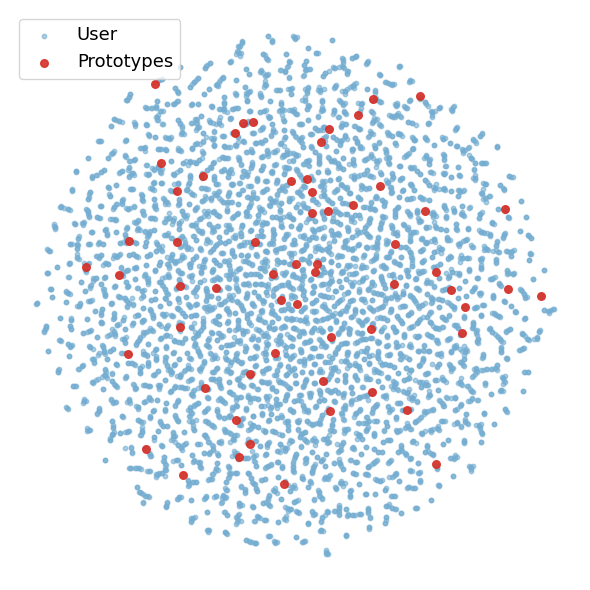

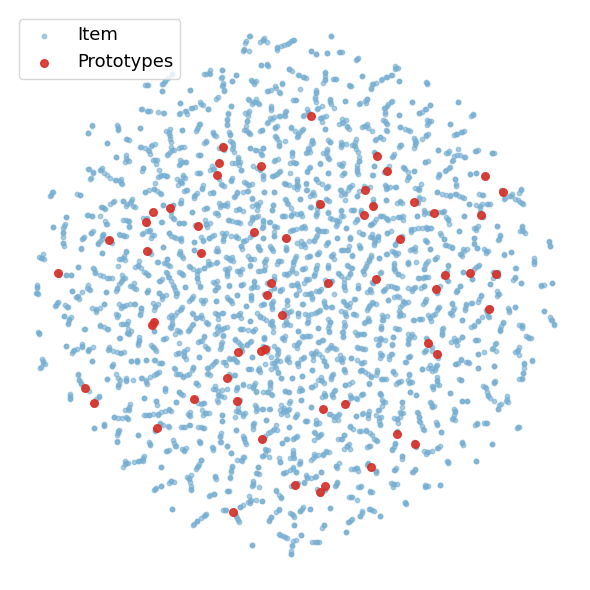

Records after item pass:  574385
Records after user pass:  574376
Records after item pass:  574376
Records after user pass:  574376
Exiting...


C:\Users\Alexey\AppData\Local\Temp\ipykernel_10732\2545903657.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['movieid'] = movie_df['movieid'].apply(lambda id: np.where(data_index_items==id)[0].item())


--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 60 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

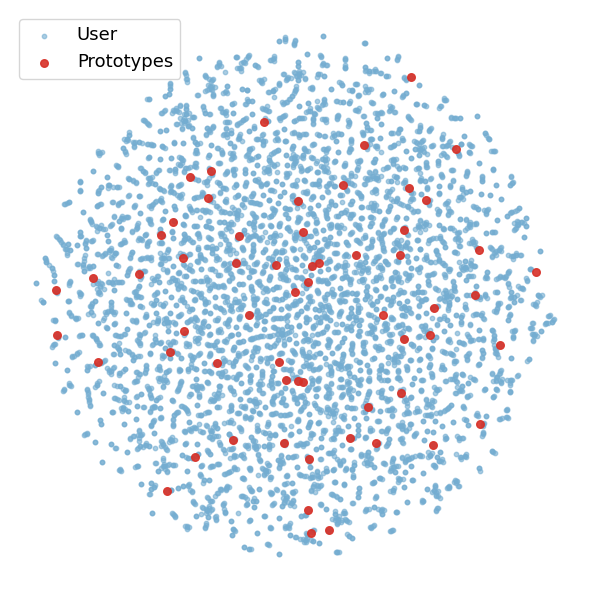

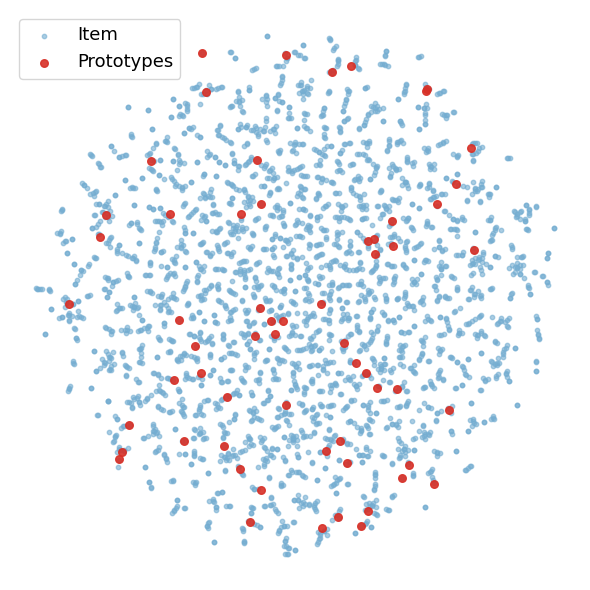

Records after item pass:  574385
Records after user pass:  574376
Records after item pass:  574376
Records after user pass:  574376
Exiting...


C:\Users\Alexey\AppData\Local\Temp\ipykernel_10732\2545903657.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['movieid'] = movie_df['movieid'].apply(lambda id: np.where(data_index_items==id)[0].item())


--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shifted 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 6028 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built Embeddingw model 
- out_dimension: 60 
- use_bias: False 

--- Finished building FeatureExtractor model ---

--- Building FeatureExtractor model ---
Built Embedding model 
- n_objects: 3123 
- embedding_dim: 100 
- max_norm: None
- only_positive: False
Built PrototypeEmbedding model 
- n_prototypes: 60 
- use_weight_matrix: False 
- sim_proto_weight: 0.001 
- sim_batch_weight: 0.001 
- reg_proto_type: max 
- reg_batch_type: max 
- cosine_type: shi

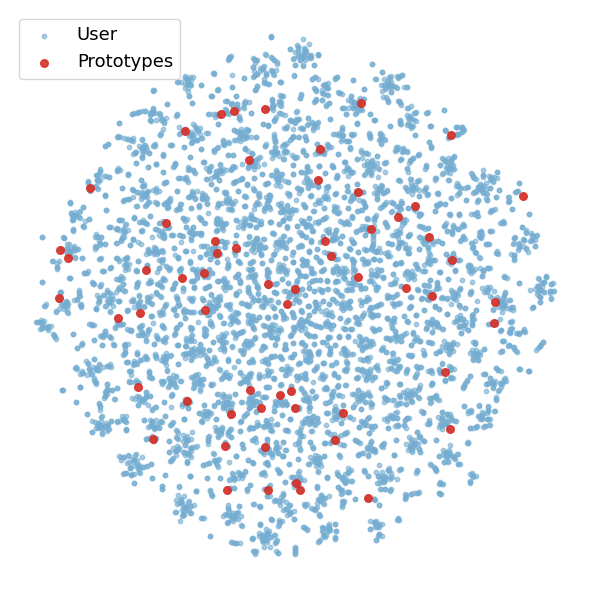

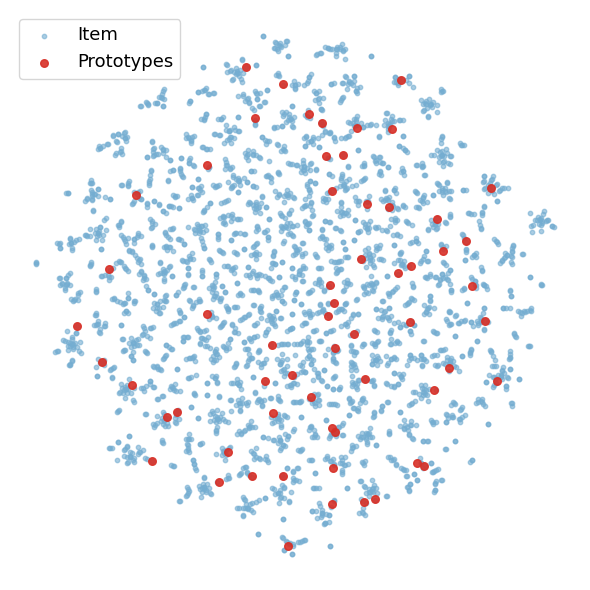

Records after item pass:  574385
Records after user pass:  574376
Records after item pass:  574376
Records after user pass:  574376
Exiting...


KeyboardInterrupt: 

In [44]:
dfs = {}
for ckpt in Path(r"experiments\full_train_tuning\12252023.225158").rglob("*.pth"):
    dfs[ckpt] = visualisation(ckpt.__str__())

In [ ]:
all_items = train.query('itemid in @test_items')['itemid'].unique()

sub_10_items = all_items[train.query('itemid in @test_items').groupby('itemid')['userid'].count() <= items_quant_10]
sub_50_items = all_items[train.query('itemid in @test_items').groupby('itemid')['userid'].count() <= items_quant_50]

all_users = train.query('userid in @test_users')['userid'].unique()

sub_10_users = sorted(all_users[train.query('userid in @test_users').groupby('userid')['itemid'].count() <= users_quant_10])
sub_50_users = sorted(all_users[train.query('userid in @test_users').groupby('userid')['itemid'].count() <= users_quant_50])

In [ ]:
normed_mat_users = np.array(((user_embeds.T) * 1 / np.linalg.norm(user_embeds, 2, axis=1)))
normed_mat_protos_user = np.array(((user_protos.T) * (1 / np.linalg.norm(user_protos, 2, axis=1))))
user_to_protos = (1 + np.dot(normed_mat_users.T, normed_mat_protos_user))
user_scores = user_to_protos.dot(items_feats.T)

normed_mat_items = np.array(((item_embeds.T) * 1 / np.linalg.norm(item_embeds, 2, axis=1)))
normed_mat_protos_item = np.array(((item_protos.T) * (1 / np.linalg.norm(item_protos, 2, axis=1))))
item_to_protos = (1 + np.dot(normed_mat_items.T, normed_mat_protos_item))
item_scores = item_to_protos.dot(user_feats.T)


In [ ]:
normed_mat_users = np.array(((user_embeds.T) * 1 / np.linalg.norm(user_embeds, 2, axis=1)))
normed_mat_protos = np.array(((user_protos.T) * (1 / np.linalg.norm(user_protos, 2, axis=1))))
user_to_protos = (1 + np.dot(normed_mat_users.T, normed_mat_protos))
scores = user_to_protos.dot(items_feats.T)
top_20 = scores.argsort()[:, ::-1][:,:20]

In [ ]:
top_20

In [ ]:
valid = pd.read_excel(r'C:\Users\aleke\Downloads\KION_DATASET\ProtoMF\data\ml\valid_ml_our_split.xlsx')
test = pd.read_excel(r'C:\Users\aleke\Downloads\KION_DATASET\ProtoMF\data\ml\test_ml_our_split.xlsx')
train= pd.read_excel(r'C:\Users\aleke\Downloads\KION_DATASET\ProtoMF\data\ml\train_ml_our_split.xlsx')

In [ ]:
def hr_score(top_n_items, real_likes):
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return mask.any(axis=1).mean()

def mrr_score(top_n_items, real_likes):
    idx = np.arange(1, top_n_items.shape[1] + 1)[None, :]
    mask = (top_n_items[...,None] == real_likes[:,None]).any(2)
    return (mask / idx).max(axis=1).mean()

def coverage_score(top_n_items, total_item_count):
    return len(np.unique(top_n_items)) * 1.0 / total_item_count

In [ ]:
max_likes = test.groupby('userid')['itemid'].apply(len).max()


In [ ]:
test_likes = test.groupby('userid')['itemid'].apply(lambda x: list(np.pad(x, (0, max_likes - len(x)), 'constant', constant_values=-1)))

test_users = test_likes.index
test_likes = np.asarray(list(test_likes))
hr_score(top_20[test_users], np.array(test_likes))